# Redes Neuronales

In [1]:
import json
import numpy as np
import re
import os
import pickle
from random import shuffle
from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, Embedding, Flatten, Conv1D, MaxPooling1D, GlobalMaxPool1D
from matplotlib import pyplot as plt
from gensim.models import Word2Vec
from constants import *

Using TensorFlow backend.


ImportError: No module named 'gensim'

### Funciones auxiliares

In [2]:
def save_json(data, filename):
    with open(filename, 'w') as f:
        json.dump(data, f)

def load_json(filename):
    with open(filename, 'r') as f:
        file = json.load(f)
    
    return file

In [3]:
def plt_history(data, filename):
    plt.title('Model accuracy')
    for i in data[:2]:
        plt.plot(i)
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['acc', 'val_acc'])
    plt.grid()
    plt.savefig(os.path.join('graph', 'acc_' + filename + '.png'))
    plt.show()
    plt.title('Model accuracy')
    for i in data[2:]:
        plt.plot(i)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['loss', 'val_loss'])
    plt.grid()
    plt.savefig(os.path.join('graph', 'loss_' + filename + '.png'))
    plt.show()

In [4]:
def train_model(model, x_train, y_train, batch_size, epochs, data):
    history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=VAL_SIZE)
    data[0] += history.history['acc']
    data[1] += history.history['val_acc']
    data[2] += history.history['loss']
    data[3] += history.history['val_loss']
    return data

In [5]:
def pro_train(model, x_train, y_train, batch_size, filename):
    data = [[],[],[],[]]
    cont = True
    best_acc = 0

    while cont:
        data = train_model(model, x_train, y_train, batch_size, 1, data)
        if best_acc < data[1][-1]:
            best_acc = data[1][-1]
            model.save('model/' + filename)
            print("Saved to disk")
        if len(data[3]) > 2:
            if data[3][-1] > data[3][-2] and data[3][-2] > data[3][-3]:
                cont = False
    
    model = load_model('model/' + filename)
    return model, data

In [6]:
def print_predictions(predictions):
    for pred in predictions:
        pred_cat = []
        for i in range(len(pred)):
            pred_cat.append((pred[i], categories[i]))
        result = sorted(pred_cat, key=lambda x: -x[0])
        print("=============")
        for elem in result:
            if elem[0] >= 0.01:
                print(elem)

In [7]:
def get_best_predictions(predictions):
    pred_cat = []
    for i in range(len(predictions)):
        pred_cat.append((predictions[i], categories[i]))
    result = sorted(pred_cat, key=lambda x: -x[0])
    result = [x for x in result if x[0] >= 0.6]
    return result

def show_securely_pred_songs(songs, predictions):
    song_pred = []
    for i in range(len(songs)):
        song_pred.append((songs[i], get_best_predictions(predictions[i])))
    
    for song in song_pred:
        if len(song[1]) > 0:
            print(song[0])
            print(song[1])
            print("""\n===================\n""")

In [8]:
cnn_text = """
Sutherland Springs, Texas (CNN)The congregation of First Baptist Church of Sutherland Springs held a service on Sunday, one week after a gunman opened fire in the church, killing 25 people and an unborn child in the deadliest mass shooting in Texas history.

Sunday's service was held just a few blocks away from the church beneath a white tent on a baseball field, closely guarded by Texas Department of Public Safety agents, sheriff's deputies and emergency management officers.
Attendees filled about 500 seats in the makeshift sanctuary, which held a small podium for Sunday's speakers and a wooden cross enveloped white lights. The remaining guests stood in the back.
Security becomes a top priority for churches after Texas massacre
Pastors and churches from around the area organized the service, while First Baptist Church's pastor, Frank Pomeroy -- whose 14-year-old daughter was killed in the shooting -- spoke.
Pomeroy urged those gathered to "choose life," rather than "darkness" as the gunman had.
"Victory has a price," he told them. "You cannot be victorious in battle without being wounded in battle."
At one point, Pomeroy began to break down while speaking.
"I know everyone who lost their life that day," he said, "some of which were my best friends, and my daughter, and I guarantee without any shadow of a doubt they are dancing with Jesus today. God gets the glory."
Read more: Why the church shooting hasn't changed rural Texans' minds about guns
Texas Sen. John Cornyn also made remarks during the service.
"It's clear they're people of deep faith," Cornyn said of the congregation in an impromptu press conference following the service. "And that's what sustains them and gives them hope, even during dark times like this."
Cornyn spoke highly of Pomeroy and his faith, which endures despite having suffered his own tragic loss.
"I saw him standing there at the front of the church, comforting others," Cornyn said. "It's remarkable, but it's a testament to their faith and their compassion for others during this very difficult time."
People from around the state and distant corners of the country traveled to show their support for the small Texas community, home to about 600 residents. One man drove from Dallas, while another couple told CNN they drove from North Carolina.
Texas church to open as memorial one week after mass shooting
The church's services were typically attended by no more than several dozen people, who gathered within the church's white walls, singing hymns led by a small worship band.
On Saturday, the church announced the sanctuary would be open to the public on Sunday evening, having been "transformed into a beautiful memorial that celebrates and pays tribute to the lives that were lost."
"I want everyone that walks in there to know that the people who died lived for their Lord and savior, and would want them to live as well," Pomeroy said Sunday afternoon.
Next Sunday's church service will return to the sanctuary where last week's attack was carried out, and Sunday school classes will resume, former associate pastor Mark Collins announced at the end of the service.
"""
cnn_text = re.sub('\n', ' ', cnn_text)
cnn_text = re.sub('\d+', 'NUMBER', cnn_text)
cnn_text = re.sub('\s+', ' ', cnn_text).strip()

### Cargo los datos preprocesados

In [9]:
docs = load_json(NEWS_DOC_FILENAME)
songs = load_json(SONGS_DOC_FILENAME)
categories = load_json(CATEGORIES_FILENAME)

---

## Primera Red Neuronal sin Embeddings

In [10]:
shuffle(docs)

train = docs[int(len(docs) * TEST_SIZE):]
test = docs[:int(len(docs) * TEST_SIZE)]

In [18]:
MAX_WORDS = 1000

In [19]:
tokenizer = Tokenizer(num_words=MAX_WORDS)

tokenizer.fit_on_texts([item[0] for item in train])

In [37]:
with open('model/tokenizer_' + str(MAX_WORDS), 'wb') as f:
    pickle.dump(tokenizer, f)

In [38]:
matrix_train = tokenizer.texts_to_matrix([item[0] for item in train])
matrix_test = tokenizer.texts_to_matrix([item[0] for item in test])

In [39]:
y_train = to_categorical([item[1] for item in train], len(categories))
y_test = to_categorical([item[1] for item in test], len(categories))

### Estructura

In [44]:
DENSE = 256

In [45]:
model_normal = Sequential()
model_normal.add(Dense(DENSE, input_shape=(MAX_WORDS,), activation='relu'))
model_normal.add(Dropout(0.5))
model_normal.add(Dense(len(categories), activation='softmax'))

model_normal.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_normal.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 256)               1280256   
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 20)                5140      
Total params: 1,285,396
Trainable params: 1,285,396
Non-trainable params: 0
_________________________________________________________________


### Entrenamiento

In [46]:
model_normal, data = pro_train(model_normal, matrix_train, y_train, BATCH_SIZE, 'red_normal_w' + str(MAX_WORDS) + '_d' + str(DENSE))

Train on 15222 samples, validate on 1692 samples
Epoch 1/1
15222/15222 [==============================] - 4s 272us/step - loss: 1.9271 - acc: 0.5148 - val_loss: 1.0347 - val_acc: 0.8002
Saved to disk
Train on 15222 samples, validate on 1692 samples
Epoch 1/1
15222/15222 [==============================] - 4s 263us/step - loss: 0.7938 - acc: 0.8161 - val_loss: 0.7062 - val_acc: 0.8511
Saved to disk
Train on 15222 samples, validate on 1692 samples
Epoch 1/1
15222/15222 [==============================] - 4s 260us/step - loss: 0.5157 - acc: 0.8826 - val_loss: 0.5960 - val_acc: 0.8528
Saved to disk
Train on 15222 samples, validate on 1692 samples
Epoch 1/1
15222/15222 [==============================] - 4s 260us/step - loss: 0.3683 - acc: 0.9190 - val_loss: 0.5353 - val_acc: 0.8605
Saved to disk
Train on 15222 samples, validate on 1692 samples
Epoch 1/1
15222/15222 [==============================] - 4s 262us/step - loss: 0.2786 - acc: 0.9406 - val_loss: 0.5068 - val_acc: 0.8635
Saved to disk


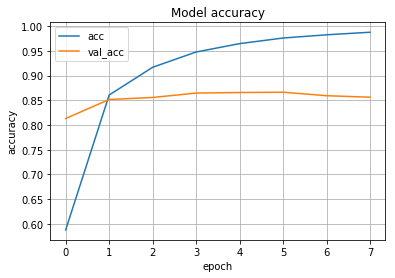

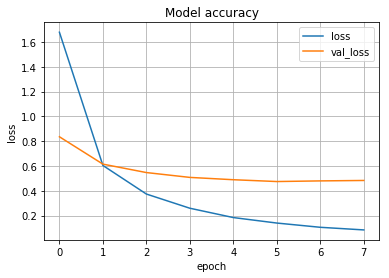

In [43]:
plt_history(data, 'red_normal_w' + str(MAX_WORDS) + '_d' + str(DENSE))

In [17]:
model_normal = load_model(MODEL_NORMAL_FILENAME)

In [18]:
score = model_normal.evaluate(matrix_test, y_test,
                              batch_size=BATCH_SIZE, verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1])

1879/1879 [==============================] - 1s 315us/step
Test score: 0.382496506563
Test accuracy: 0.893560405359


### Pruebas

In [19]:
cnn_matrix = tokenizer.texts_to_matrix([cnn_text])
predictions = model_normal.predict(cnn_matrix)

In [20]:
print_predictions(predictions)

(0.97226274, 'soc.religion.christian')
(0.013358118, 'talk.politics.guns')


In [21]:
songs_matrix = tokenizer.texts_to_matrix(songs)
predictions = model_normal.predict(songs_matrix)

In [22]:
show_securely_pred_songs(songs, predictions)

Nightmare!. . . Dragged you down below down to the devils show. To be his guest forever . Peace of mind is less than never. . Hate to twist your mind but God aint on your side . An old acquaintance severed. Burn the world your last endeavor. . Flesh is burning you can smell it in the air. Cause men like you have such an easy soul to steal . So stand in line while they ink numbers in your head. Youre now a slave until the end of time here. Nothing stops the madness turning. Haunting yearning pull the trigger. . You should have known the price of evil. And it hurts to know that you belong here yeah. Ooh its your fucking nightmare. . . Cant wake up in sweat cause it aint over yet. Still dancing with your demons. Victim of your own creation. . Beyond the will to fight where all thats wrong is right. Where hate dont need a reason. Loathing self assassination. . Youve been lied to just to rape you of your sight. And now they have the nerve to tell you how to feel . So sedated as they medicat

---

## Red neuronal con Embeddings Genericos

In [20]:
with open(EMBEDDINGS_FILENAME, 'r') as f:
    raw_embeddings = f.readlines()

embeddings_index = {}
    
for line in raw_embeddings:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    if word in tokenizer.word_index:
        embeddings_index[word] = coefs
        
del raw_embeddings

In [21]:
encoded_train = tokenizer.texts_to_sequences([item[0] for item in train])
encoded_test = tokenizer.texts_to_sequences([item[0] for item in test])

padded_train = pad_sequences(encoded_train, PAD)
padded_test = pad_sequences(encoded_test, PAD)

del encoded_train
del encoded_test

In [22]:
# create a weight matrix for words in training docs
vocab_size = len(tokenizer.word_index) + 1
embedding_matrix = np.zeros((vocab_size, 100))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

del embeddings_index

### Estructura

In [23]:
model_emb = Sequential()
model_emb.add(Embedding(vocab_size, 100, input_length=PAD, weights=[embedding_matrix], trainable=False))
model_emb.add(Conv1D(128, 5, activation='relu'))
model_emb.add(MaxPooling1D(5))
model_emb.add(Dropout(0.5))
model_emb.add(Conv1D(128, 5, activation='relu'))
model_emb.add(MaxPooling1D(5))
model_emb.add(Dropout(0.5))
model_emb.add(Conv1D(128, 5, activation='relu'))
model_emb.add(GlobalMaxPool1D())
model_emb.add(Dense(len(categories), activation='softmax'))

model_emb.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])
model_emb.summary()

ValueError: Negative dimension size caused by subtracting 5 from 3 for 'conv1d_3/convolution/Conv2D' (op: 'Conv2D') with input shapes: [?,1,3,128], [1,5,128,128].

### Entrenamiento

In [24]:
model_emb, data_emb = pro_train(model_emb, padded_train, y_train, BATCH_SIZE, MODEL_EMB_FILENAME)

NameError: name 'y_train' is not defined

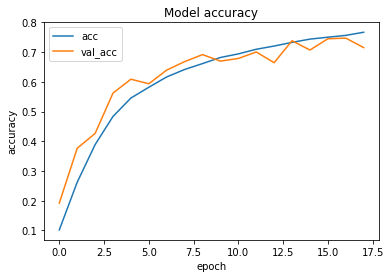

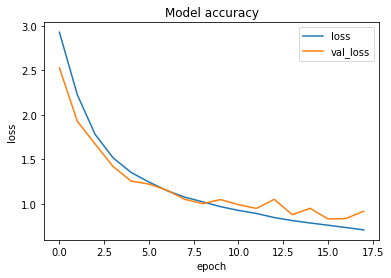

In [30]:
plt_history(data_emb)

### Pruebas

In [33]:
model_emb = load_model(MODEL_EMB_FILENAME)

In [34]:
cnn_encoded = tokenizer.texts_to_sequences([cnn_text])
cnn_pad = pad_sequences(cnn_encoded, PAD)
predictions = model_emb.predict(cnn_pad)

In [35]:
print_predictions(predictions)

(0.85219014, 'soc.religion.christian')
(0.13195688, 'talk.religion.misc')


In [36]:
songs_encoded = tokenizer.texts_to_sequences(songs)
songs_pad = pad_sequences(songs_encoded, PAD)
predictions = model_emb.predict(songs_pad)

In [37]:
show_securely_pred_songs(songs, predictions)

I am leaving you because I dont love you. I am leaving you because I dont love you. . Oh its the knowledge. Its the knowledge. Its the knowledge. Of future clarity. That makes my voice tremble. With greater dignity. . I am leaving you because I dont love you. I am leaving you because I dont love you. . Im sorry I have to be this brutally honest Nicole. But my excuses were babies of snow that I just could not hold. So you pick up your asthma inhaler and put it gainst your lips. Oh those lips Ive loved that I was dreaming of. Theyre still red and soft Im so sorry I couldnt love you enough. Im so sorry I couldnt love you enough. Im so sorry. . But Im leaving you because I dont love you. I am leaving you because I dont love you. . So you pick up your asthma inhaler and put it gainst your lips. Oh those lips Ive loved that I was dreaming of. Theyre still red and soft Im so sorry I couldnt love you enough. So sorry I couldnt love you enough. Im so sorry
[(0.67014521, 'sci.med')]


If you wan

The sounds of Christmas fill the air the shouts of girls and boys. The silver bells and all the noels make a joyful night. But once the choirs quiet down and sing their last Amen. What happens then What happens then. . If you hold your breath and listen. You might finally find what your worlds been missing. Peace heavenly peace. . In between your own hearts beating. Theres a quiet voice that keeps repeating. Peace heavenly peace. . And its all about peace can be found on a mountain top or an avenue. In the silent night in the light of day in the way I feel when Im with you. . I dont need satin balls and tissue. Not to wrap the gift that I want to wish you peace. I wish you peace heavenly peace. . Like the warming glow of the morning sun. There is enough for everyone. . In the precious time were given. What I wouldnt give if we could only live in peace. I wish you peace let there be peace. Glorious peace heavenly peace. . May your blessings multiply may your bounty never cease. And may 

---
## Red neuronal con embeddings de 20newsgroup

In [38]:
w2v_20new = Word2Vec.load(NEWS_EMB_MODEL)
#w2v_songs = Word2Vec.load(SONGS_EMB_MODEL)
#w2v_20new_songs = Word2Vec.load(NEWS_SONGS_EMB_MODEL)

#news_emb_weight = np.load(NEWS_EMB_WEIGHT)
#songs_emb_weight = np.load(SONGS_EMB_WEIGHT)
#news_song_emb_weight = np.load(NEWS_SONGS_EMB_WEIGHT)

In [39]:
# create a weight matrix for words in training docs
vocab_size = len(tokenizer.word_index) + 1

def make_embedding_matrix(w2v):
    embedding_matrix = np.zeros((vocab_size, 100))
    i = 0
    j = 0
    for word, i in tokenizer.word_index.items():
        try:
            embedding_vector = w2v.wv.word_vec(word)
            embedding_matrix[i] = embedding_vector
            j += 1
        except:
            i += 1
            pass
    return embedding_matrix

In [40]:
embedding_matrix = make_embedding_matrix(w2v_20new)

In [41]:
model_emb_20 = Sequential()
model_emb_20.add(Embedding(vocab_size, 100, input_length=PAD, weights=[embedding_matrix], trainable=False))
model_emb_20.add(Conv1D(128, 5, activation='relu'))
model_emb_20.add(MaxPooling1D(5))
model_emb_20.add(Dropout(0.5))
model_emb_20.add(Conv1D(128, 5, activation='relu'))
model_emb_20.add(MaxPooling1D(5))
model_emb_20.add(Dropout(0.5))
model_emb_20.add(Conv1D(128, 5, activation='relu'))
model_emb_20.add(GlobalMaxPool1D())
model_emb_20.add(Dense(len(categories), activation='softmax'))

model_emb_20.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])
model_emb_20.summary()

data_emb = [[],[],[],[]]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 1000, 100)         14203500  
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 996, 128)          64128     
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 199, 128)          0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 199, 128)          0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 195, 128)          82048     
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 39, 128)           0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 39, 128)           0         
__________

In [42]:
model_emb_20, data_emb_20 = pro_train(model_emb_20, padded_train, y_train, BATCH_SIZE, MODEL_EMB_NEW_FILENAME)

Train on 15222 samples, validate on 1692 samples
Epoch 1/1
15222/15222 [==============================] - 168s 11ms/step - loss: 3.3445 - acc: 0.0832 - val_loss: 2.8160 - val_acc: 0.1359
Saved to disk
Train on 15222 samples, validate on 1692 samples
Epoch 1/1
15222/15222 [==============================] - 165s 11ms/step - loss: 2.5699 - acc: 0.1596 - val_loss: 2.3980 - val_acc: 0.2293
Saved to disk
Train on 15222 samples, validate on 1692 samples
Epoch 1/1
15222/15222 [==============================] - 168s 11ms/step - loss: 2.3131 - acc: 0.2316 - val_loss: 2.2092 - val_acc: 0.3121
Saved to disk
Train on 15222 samples, validate on 1692 samples
Epoch 1/1
15222/15222 [==============================] - 165s 11ms/step - loss: 2.1157 - acc: 0.2894 - val_loss: 2.0381 - val_acc: 0.3611
Saved to disk
Train on 15222 samples, validate on 1692 samples
Epoch 1/1
15222/15222 [==============================] - 164s 11ms/step - loss: 1.9743 - acc: 0.3356 - val_loss: 1.9479 - val_acc: 0.3670
Saved to 

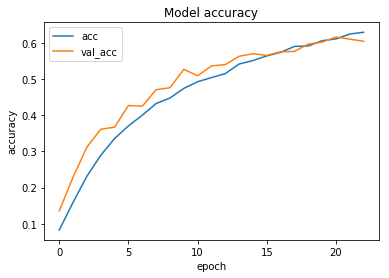

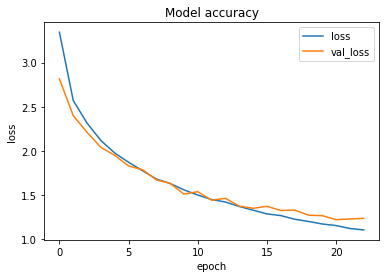

In [43]:
plt_history(data_emb_20)

### Pruebas

In [44]:
model_emb_20 = load_model(MODEL_EMB_NEW_FILENAME)

In [45]:
cnn_encoded = tokenizer.texts_to_sequences([cnn_text])
cnn_pad = pad_sequences(cnn_encoded, PAD)
predictions = model_emb_20.predict(cnn_pad)

In [46]:
print_predictions(predictions)

(0.60772735, 'talk.religion.misc')
(0.099243201, 'alt.atheism')
(0.088907734, 'talk.politics.misc')
(0.080558717, 'soc.religion.christian')
(0.070639618, 'talk.politics.guns')
(0.042576533, 'talk.politics.mideast')


In [47]:
songs_encoded = tokenizer.texts_to_sequences(songs)
songs_pad = pad_sequences(songs_encoded, PAD)
predictions = model_emb.predict(songs_pad)

In [ ]:
show_securely_pred_songs(songs, predictions)

---
## Red neuronal con embeddings de las canciones

In [48]:
w2v_songs = Word2Vec.load(SONGS_EMB_MODEL)

In [49]:
embedding_matrix = make_embedding_matrix(w2v_songs)

In [50]:
model_emb_song = Sequential()
model_emb_song.add(Embedding(vocab_size, 100, input_length=PAD, weights=[embedding_matrix], trainable=False))
model_emb_song.add(Conv1D(128, 5, activation='relu'))
model_emb_song.add(MaxPooling1D(5))
model_emb_song.add(Dropout(0.5))
model_emb_song.add(Conv1D(128, 5, activation='relu'))
model_emb_song.add(MaxPooling1D(5))
model_emb_song.add(Dropout(0.5))
model_emb_song.add(Conv1D(128, 5, activation='relu'))
model_emb_song.add(GlobalMaxPool1D())
model_emb_song.add(Dense(len(categories), activation='softmax'))

model_emb_song.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])
model_emb_song.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 1000, 100)         14203500  
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 996, 128)          64128     
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 199, 128)          0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 199, 128)          0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 195, 128)          82048     
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 39, 128)           0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 39, 128)           0         
__________

In [54]:
model_emb_song, data_emb_song = pro_train(model_emb_song, padded_train, y_train, BATCH_SIZE, MODEL_EMB_SONG_FILENAME)

Train on 15222 samples, validate on 1692 samples
Epoch 1/1
15222/15222 [==============================] - 165s 11ms/step - loss: 2.0147 - acc: 0.3542 - val_loss: 2.1594 - val_acc: 0.3079
Saved to disk
Train on 15222 samples, validate on 1692 samples
Epoch 1/1
15222/15222 [==============================] - 164s 11ms/step - loss: 2.0003 - acc: 0.3605 - val_loss: 2.0977 - val_acc: 0.3363
Saved to disk
Train on 15222 samples, validate on 1692 samples
Epoch 1/1
15222/15222 [==============================] - 166s 11ms/step - loss: 1.9891 - acc: 0.3678 - val_loss: 2.1082 - val_acc: 0.3280
Train on 15222 samples, validate on 1692 samples
Epoch 1/1
15222/15222 [==============================] - 167s 11ms/step - loss: 1.9611 - acc: 0.3695 - val_loss: 2.0845 - val_acc: 0.3475
Saved to disk
Train on 15222 samples, validate on 1692 samples
Epoch 1/1
15222/15222 [==============================] - 163s 11ms/step - loss: 1.9640 - acc: 0.3683 - val_loss: 2.0941 - val_acc: 0.3428
Train on 15222 samples,

In [52]:
model_emb_song = load_model(MODEL_EMB_SONG_FILENAME)

In [55]:
score = model_emb_song.evaluate(padded_test, y_test,
                                batch_size=BATCH_SIZE, verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1])

1879/1879 [==============================] - 7s 4ms/step
Test score: 1.98651810286
Test accuracy: 0.383182543335


---
## Red neuronal con embeddings de 20news y de las canciones

In [56]:
w2v_news_songs = Word2Vec.load(NEWS_SONGS_EMB_MODEL)

In [57]:
embedding_matrix = make_embedding_matrix(w2v_news_songs)

In [58]:
model_emb_news_songs = Sequential()
model_emb_news_songs.add(Embedding(vocab_size, 100, input_length=PAD, weights=[embedding_matrix], trainable=False))
model_emb_news_songs.add(Conv1D(128, 5, activation='relu'))
model_emb_news_songs.add(MaxPooling1D(5))
model_emb_news_songs.add(Dropout(0.5))
model_emb_news_songs.add(Conv1D(128, 5, activation='relu'))
model_emb_news_songs.add(MaxPooling1D(5))
model_emb_news_songs.add(Dropout(0.5))
model_emb_news_songs.add(Conv1D(128, 5, activation='relu'))
model_emb_news_songs.add(GlobalMaxPool1D())
model_emb_news_songs.add(Dense(len(categories), activation='softmax'))

model_emb_news_songs.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])
model_emb_news_songs.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 1000, 100)         14203500  
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 996, 128)          64128     
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 199, 128)          0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 199, 128)          0         
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 195, 128)          82048     
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 39, 128)           0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 39, 128)           0         
__________

In [59]:
model_emb_news_songs, data_emb_news_songs = pro_train(model_emb_song, padded_train, y_train, BATCH_SIZE, MODEL_EMB_NEW_SONG_FILENAME)

Train on 15222 samples, validate on 1692 samples
Epoch 1/1
15222/15222 [==============================] - 169s 11ms/step - loss: 1.8252 - acc: 0.4072 - val_loss: 2.0158 - val_acc: 0.3753
Saved to disk
Train on 15222 samples, validate on 1692 samples
Epoch 1/1
15222/15222 [==============================] - 167s 11ms/step - loss: 1.7909 - acc: 0.4228 - val_loss: 2.0297 - val_acc: 0.3499
Train on 15222 samples, validate on 1692 samples
Epoch 1/1
15222/15222 [==============================] - 164s 11ms/step - loss: 1.8127 - acc: 0.4187 - val_loss: 2.0039 - val_acc: 0.3623
Train on 15222 samples, validate on 1692 samples
Epoch 1/1
15222/15222 [==============================] - 167s 11ms/step - loss: 1.7906 - acc: 0.4223 - val_loss: 2.0166 - val_acc: 0.3658
Train on 15222 samples, validate on 1692 samples
Epoch 1/1
15222/15222 [==============================] - 165s 11ms/step - loss: 1.7808 - acc: 0.4271 - val_loss: 1.9879 - val_acc: 0.3700
Train on 15222 samples, validate on 1692 samples
Ep